In [150]:
print('hello world')

hello world


In [151]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [152]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
uniq=list(set(c for w in words for c in w))
uniq= uniq + ['.']
vocab=sorted(uniq)
stoi = {c:i for i,c in enumerate(vocab) }
itos = {i:s for s,i in stoi.items()}

In [154]:
vocab_len=len(vocab)
vocab_len

27

In [155]:
block_size=3
X,Y=[],[]
for w in words[:5]:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [156]:
X.shape,Y.shape


(torch.Size([32, 3]), torch.Size([32]))

In [157]:
n_emb=2
C=torch.randn((vocab_len, 2))
C.shape

torch.Size([27, 2])

In [158]:
emb=C[X]
print(emb.shape)

emb[3], X[3], C[[5,13,13]]

torch.Size([32, 3, 2])


(tensor([[-2.1406,  0.5764],
         [-0.1223,  0.8116],
         [-0.1223,  0.8116]]),
 tensor([ 5, 13, 13]),
 tensor([[-2.1406,  0.5764],
         [-0.1223,  0.8116],
         [-0.1223,  0.8116]]))

In [159]:
n_neurons=100
W1 = torch.randn((block_size*n_emb, n_neurons))
b1 = torch.randn(n_neurons)
W1.shape, b1.shape



(torch.Size([6, 100]), torch.Size([100]))

In [160]:
W2 = torch.randn((n_neurons, vocab_len))
b2 = torch.randn(vocab_len)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [ ]:
hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
probs =  F.softmax(logits, 1)

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

In [304]:
# train prep
n_emb=2
n_neurons=100
block_size=3

X,Y=[],[]
for w in words:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    #print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

g = torch.Generator().manual_seed(782361)

# init
C  = torch.randn((vocab_len, n_emb),            generator=g)
W1 = torch.randn((block_size*n_emb, n_neurons), generator=g) * 0.2
b1 = torch.randn(n_neurons,                     generator=g) * 0.001
W2 = torch.randn((n_neurons, vocab_len),        generator=g) * 0.1
b2 = torch.randn(vocab_len,                     generator=g) * 0.001

parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

In [305]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [306]:
lossi = []

In [307]:
# train
lr = 0.1

for _ in range(10_000):
  # minibatch
  batch = torch.randint(0, X.shape[0], (64,), generator=g)

  # forward pass
  emb=C[X[batch]]
  hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[batch])
  
  # clear grads
  for p in parameters:
    p.grad = None
  # recompute grads
  loss.backward()
  # update
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.item())
  #break
loss

tensor(2.3641, grad_fn=<NllLossBackward0>)

(array([649., 259., 190., 143., 159., 144.,  93., 128., 119., 137., 101.,
        119.,  96., 101., 131.,  96.,  88.,  86.,  86.,  85.,  74.,  86.,
         59.,  69.,  79.,  71.,  60.,  60.,  94.,  90.,  93.,  93.,  85.,
         87.,  68.,  77.,  81.,  90., 104., 129., 102., 105.,  91., 123.,
        129., 134., 125., 173., 210., 549.]),
 array([-9.99999940e-01, -9.59999963e-01, -9.19999986e-01, -8.80000008e-01,
        -8.40000031e-01, -8.00000054e-01, -7.60000076e-01, -7.20000099e-01,
        -6.80000122e-01, -6.40000144e-01, -6.00000167e-01, -5.60000190e-01,
        -5.20000212e-01, -4.80000235e-01, -4.40000257e-01, -4.00000280e-01,
        -3.60000303e-01, -3.20000325e-01, -2.80000348e-01, -2.40000371e-01,
        -2.00000393e-01, -1.60000416e-01, -1.20000439e-01, -8.00004613e-02,
        -4.00004840e-02, -5.06639481e-07,  3.99994707e-02,  7.99994481e-02,
         1.19999425e-01,  1.59999403e-01,  1.99999380e-01,  2.39999357e-01,
         2.79999335e-01,  3.19999312e-01,  3.59999

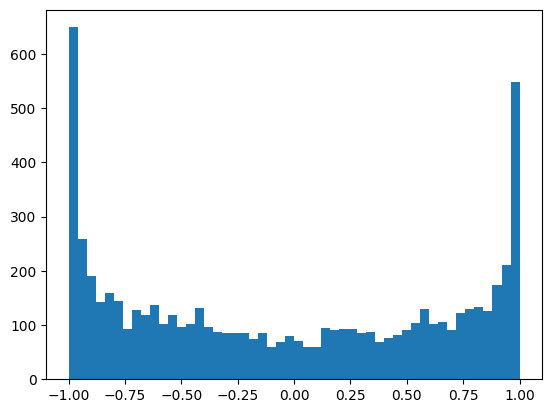

In [308]:
plt.hist(h.view(-1).tolist(), 50)

(array([ 11.,  11.,   0.,   1.,   1.,   0.,   2.,   5.,  15.,  22.,   9.,
          7.,  25.,  33.,   8.,  25.,  26.,  70.,  79., 103., 107., 153.,
        246., 321., 400., 626., 672., 562., 644., 567., 415., 332., 245.,
        152., 117.,  90.,  66.,  31.,  37.,  42.,  28.,  13.,  15.,  24.,
         14.,   2.,   0.,   1.,  13.,  12.]),
 array([-8.95498943, -8.63145051, -8.30791159, -7.98437266, -7.66083374,
        -7.33729482, -7.01375589, -6.69021697, -6.36667805, -6.04313912,
        -5.7196002 , -5.39606128, -5.07252235, -4.74898343, -4.42544451,
        -4.10190558, -3.77836666, -3.45482774, -3.13128881, -2.80774989,
        -2.48421097, -2.16067204, -1.83713312, -1.5135942 , -1.19005527,
        -0.86651635, -0.54297743, -0.21943851,  0.10410042,  0.42763934,
         0.75117826,  1.07471719,  1.39825611,  1.72179503,  2.04533396,
         2.36887288,  2.6924118 ,  3.01595073,  3.33948965,  3.66302857,
         3.9865675 ,  4.31010642,  4.63364534,  4.95718427,  5.28072319,
 

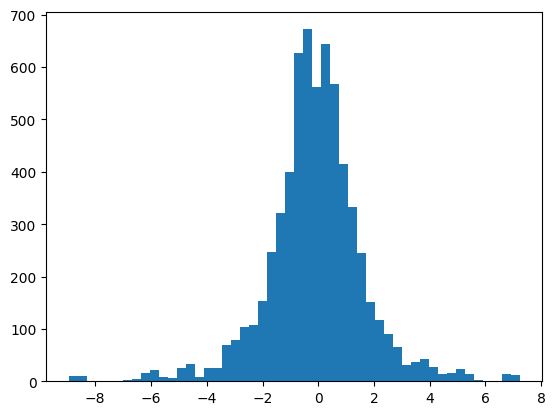

In [309]:
plt.hist(hpreact.view(-1).tolist(), 50)

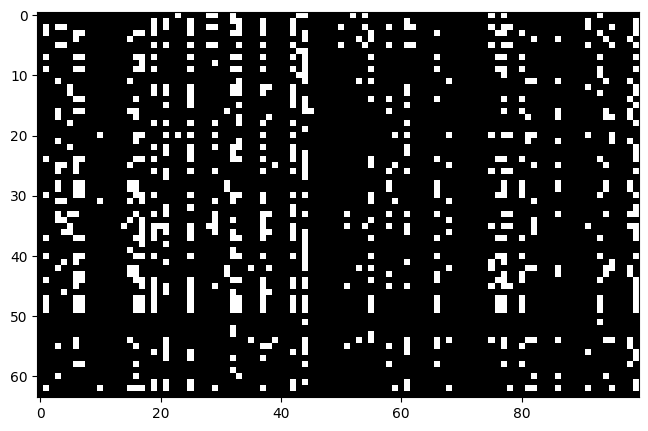

In [310]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray')

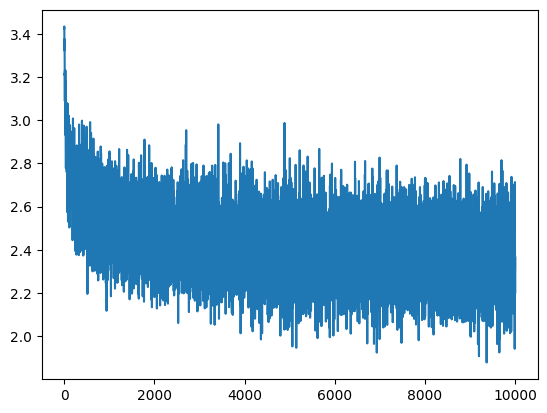

In [311]:
plt.plot(lossi)

In [225]:
# init estimate loss
-torch.tensor(1/vocab_len).log()

tensor(3.2958)

(array([  24.,   44.,   82.,  303., 1227., 3071., 1261.,  266.,   94.,
          28.]),
 array([-8.95498943, -7.33729482, -5.7196002 , -4.10190558, -2.48421097,
        -0.86651635,  0.75117826,  2.36887288,  3.9865675 ,  5.60426211,
         7.22195673]),
 <BarContainer object of 10 artists>)

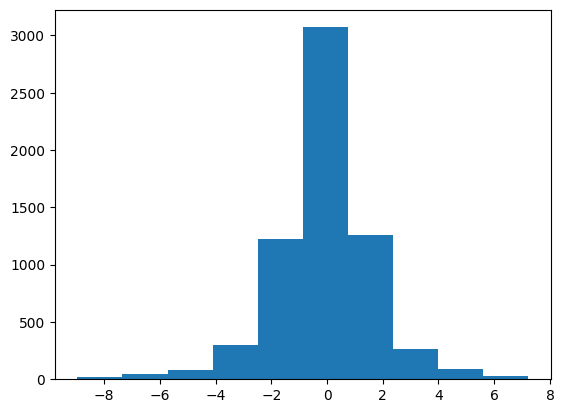

In [312]:
plt.hist(hpreact.view(-1).tolist())


(array([ 52., 156., 348., 436., 366., 194.,  96.,  53.,  17.,  10.]),
 array([-3.78669643, -2.8072135 , -1.82773056, -0.84824762,  0.13123531,
         1.11071825,  2.09020119,  3.06968412,  4.04916706,  5.02865   ,
         6.00813293]),
 <BarContainer object of 10 artists>)

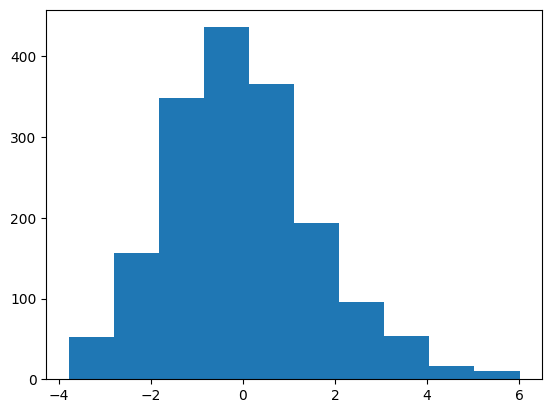

In [313]:
plt.hist(logits.view(-1).tolist())

In [317]:
# inference
out=[]
for i in range(5):
  out.append([])
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context]
    hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, 1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out[i].append(hit)
    if hit == 0:
      break
    context = context[1:] + [hit]
for o in out:
  print(''.join(itos[x] for x in o))

marankiorini.
daia.
rishelezienolta.
def.
havicishopttana.
